# Autoencoder Model on MNIST dataset

In [14]:
import torch

torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()
%matplotlib inline

plt.rcParams['figure.dpi'] = 200

Loading BokehJS ...

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Model implementation

### Encoder class

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

### Decoder class

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.view((-1, 1, 28, 28))

### Autoencoder class

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

## Training

In [6]:
def train(model, data, epochs=20):
    optim = torch.optim.Adam(model.parameters())
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device)
            optim.zero_grad()
            x_hat = model(x)
            loss = criterion(x_hat, x)
            loss.backward()
            optim.step()
        print(f'epoch:{epoch} loss:{loss}')
    return model

## Dataset

In [7]:
from torch.utils.data import DataLoader
data = DataLoader(
    torchvision.datasets.MNIST(
        '.pytorch/autoencodermnist', transform=torchvision.transforms.ToTensor(), download=True
    ),
    batch_size=128,
    shuffle=True,
    drop_last=True
)

In [8]:
latent_dims = 16
ae = Autoencoder(latent_dims).to(device)
autoencoder = train(ae, data)

epoch:0 loss:0.017505861818790436
epoch:1 loss:0.01469348929822445
epoch:2 loss:0.013206742703914642
epoch:3 loss:0.012991558760404587
epoch:4 loss:0.011333274655044079
epoch:5 loss:0.010835587047040462
epoch:6 loss:0.01065313071012497
epoch:7 loss:0.010580831207334995
epoch:8 loss:0.009721961803734303
epoch:9 loss:0.01094615738838911
epoch:10 loss:0.009810364805161953
epoch:11 loss:0.01034704502671957
epoch:12 loss:0.009544317610561848
epoch:13 loss:0.00858247559517622
epoch:14 loss:0.00950076524168253
epoch:15 loss:0.009303118102252483
epoch:16 loss:0.009792105294764042
epoch:17 loss:0.008658215403556824
epoch:18 loss:0.0089794946834445
epoch:19 loss:0.00883788987994194


## Visualize latent space

In [9]:
vis_element = []
ys = []
def get_latent(model, data):
    for i, (x, y) in enumerate(data):
        z = model.encoder(x.to(device))
        vis_element.extend(z.to('cpu').detach().numpy())
        ys.extend(y.to('cpu').detach().numpy())

get_latent(autoencoder, data)

In [10]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
vis_latent = tsne.fit_transform(vis_element)

In [69]:
from bokeh.transform import linear_cmap
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="vector T-SNE for latent space")

source = ColumnDataSource(data=dict(x1=vis_latent[:,0],
                                    x2=vis_latent[:,1],
                                    y=ys,
                                    names=ys))

p.scatter(x="x1", y="x2", size=8, source=source,
          line_color=None,
          fill_color=linear_cmap('y', 'Turbo256', 0, 9),
          legend_field='y'
          )

digit = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                       text_font_size="4pt", text_color="#555555",
                       source=source, text_align='center',render_mode='canvas')
# p.add_layout(digit)

show(p)

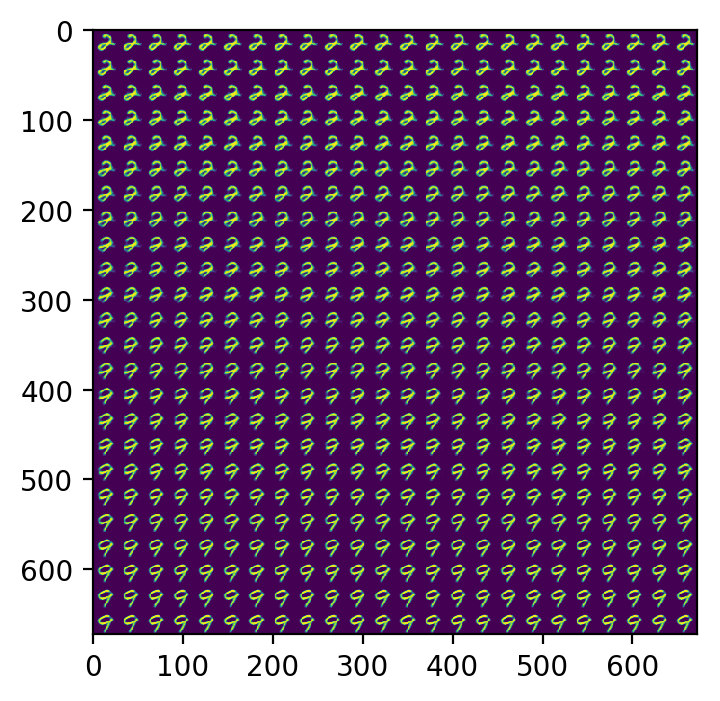

In [97]:
def plot_reconstructed(model, r0=vis_element[-1], r1=vis_element[500], n=24):
    w = 28
    img = np.zeros((n*w, n*w))
    results = np.linspace(r0.reshape(1, -1), r1.reshape(1, -1), num=n)
    for i, y in enumerate(results):
        for j in range(n):
            z = torch.Tensor(y).to(device)
            x_hat = model.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img)
plot_reconstructed(autoencoder)